In [6]:
%cd FS-Mol

[Errno 2] No such file or directory: 'FS-Mol'
/notebooks


In [1]:
import torch
from dpu_utils.utils import run_and_debug, RichPath
from fs_mol.data import FSMolDataset, FSMolTaskSample, DataFold
from fs_mol.models.protonet import PrototypicalNetwork
from fs_mol.custom.data import generate_episodic_iterable
from fs_mol.custom.model import SimpleGraphConv


from fs_mol.data.protonet import (
    ProtoNetBatch,
    get_protonet_task_sample_iterable,
    get_protonet_batcher,
    task_sample_to_pn_task_sample,
)

fsmol_dataset = FSMolDataset.from_directory(
        directory=RichPath.create('datasets/fs-mol/'),
        task_list_file=RichPath.create('datasets/fsmol-0.1.json'), num_workers=0)

# Adding a `,` will cause the variable to become a singke tuple


/Users/athecoder/FS-Mol/env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys, importlib

import torch
from fs_mol.custom.data import generate_episodic_iterable
from fs_mol.custom.model import SimpleGraphConv

train_iterable = generate_episodic_iterable(fsmol_dataset, DataFold.TRAIN)

device = 'cuda' if torch.cuda.is_available() else 'cpu'


model = SimpleGraphConv().to(device)

In [3]:
from numpy import dtype
import torch
from fs_mol.custom.utils import convert_to_pyg_graph
from torch_geometric.loader import DataLoader
from torch.optim import Adam
import torch.nn.functional as F

optm = Adam(model.parameters())

losses = []

def Average(lst):
    return sum(lst) / len(lst)


for task in train_iterable:
    support_samples = task.train_samples
    query_samples = task.test_samples

    support_sample_graphs = list(map(lambda x: convert_to_pyg_graph(x, device=device), support_samples))

    query_sample_graphs = list(map(lambda x: convert_to_pyg_graph(x, device=device), query_samples))

    for batch in DataLoader(support_sample_graphs, batch_size=len(support_sample_graphs), shuffle=True):
        optm.zero_grad()
        encoded_support_examples = model(batch, batch.batch)

        class_one_indices = (batch.y == 0).nonzero().squeeze(-1)
        class_two_indices = (batch.y == 1).nonzero().squeeze(-1)

        class_one_vectors = encoded_support_examples[class_one_indices]
        class_two_vectors = encoded_support_examples[class_two_indices]

        class_one_mean = class_one_vectors.mean(dim=0)
        class_two_mean = class_two_vectors.mean(dim=0)

        means = torch.vstack([class_one_mean, class_two_mean])

        for query_batch in DataLoader(query_sample_graphs, batch_size=len(query_sample_graphs), shuffle=True):
            encoded_query_examples = model(query_batch, query_batch.batch)

            distances = (means @ encoded_query_examples.t()).t()

            loss = F.cross_entropy(distances, query_batch.y)
            loss.backward()

            optm.step()
            losses.append(loss.item())
    
    print(Average(losses))


7.74699592590332
4.848016917705536
5.060467839241028
4.060458034276962
3.4685513496398928
7.464049418767293
6.685004472732544
6.482004135847092
5.8517959581481085
5.336916887760163
5.227851661768827
5.893453409274419
6.52497164102701
6.2178031631878445
5.978040480613709
5.703562639653683
5.549973298521603
5.339247763156891
5.223535368317052
5.01622816324234
4.875886417570568
4.685071622783488
4.871647982493691
4.716726002593835
4.582151081562042
4.480991874749844
4.426340171584377
4.302618037377085
4.234833735844185
4.154806254307429
4.055301195190799
4.034584729000926
3.9352473165049697
3.860147882910336
3.763261011668614
3.7597418361239963
3.7183488317438074
3.653952846401616
3.608600527812273
3.5374699532985687
3.4722902018849444
3.4032038705689565
3.3506866859835247
3.3677037331190975
3.325014583269755
3.2721408955428912
3.2466160173111773
3.1933562755584717
3.1432684015254586
3.095721527338028
3.0699433988215876
3.086291853051919
3.0413801456397436
2.997219896978802
3.084264615449

In [4]:
from collections import Counter
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve, auc


def delta_calc_auc_pr(l, t):
    z = Counter(l)
    pos_percentage = z[1] / len(l)

    precision, recall, thresholds = precision_recall_curve(l, t)

    return auc(recall, precision) - pos_percentage



In [6]:
test_task_iterable = generate_episodic_iterable(fsmol_dataset, DataFold.TEST)

eval_metric = []


for task in test_task_iterable:
    support_samples = task.train_samples
    query_samples = task.test_samples

    support_sample_graphs = list(map(convert_to_pyg_graph, support_samples))

    query_sample_graphs = list(map(convert_to_pyg_graph, query_samples))

    for batch in DataLoader(support_sample_graphs, batch_size=len(support_sample_graphs), shuffle=True):
        encoded_support_examples = model(batch, batch.batch)

        class_one_indices = (batch.y == 0).nonzero().squeeze(-1)
        class_two_indices = (batch.y == 1).nonzero().squeeze(-1)

        class_one_vectors = encoded_support_examples[class_one_indices]
        class_two_vectors = encoded_support_examples[class_two_indices]

        class_one_mean = class_one_vectors.mean(dim=0)
        class_two_mean = class_two_vectors.mean(dim=0)

        means = torch.vstack([class_one_mean, class_two_mean])

        for query_batch in DataLoader(query_sample_graphs, batch_size=len(query_sample_graphs), shuffle=True):
            encoded_query_examples = model(query_batch, query_batch.batch)

            distances = (means @ encoded_query_examples.t()).t()

            softmax_result = F.softmax(distances, dim=1)

            probabilities = softmax_result[range(softmax_result.shape[0]), query_batch.y].tolist()
            
            delta_auprc = delta_calc_auc_pr(query_batch.y.tolist(), probabilities)

            eval_metric.append(delta_auprc)
            


Counter({0: 166, 1: 90})
Counter({0: 119, 1: 119})
Counter({0: 47, 1: 46})
Counter({0: 47, 1: 46})
Counter({0: 48, 1: 45})
Counter({1: 128, 0: 128})
Counter({0: 48, 1: 22})
Counter({0: 81, 1: 81})
Counter({0: 47, 1: 46})
Counter({0: 47, 1: 46})
Counter({0: 154, 1: 102})
Counter({0: 141, 1: 115})
Counter({0: 49, 1: 44})
Counter({0: 47, 1: 46})
Counter({1: 46, 0: 46})
Counter({0: 49, 1: 44})
Counter({0: 67, 1: 67})
Counter({0: 157, 1: 99})
Counter({0: 47, 1: 46})
Counter({1: 88, 0: 88})
Counter({0: 40, 1: 38})
Counter({0: 36, 1: 35})
Counter({0: 47, 1: 46})
Counter({1: 128, 0: 128})
Counter({0: 47, 1: 46})
Counter({0: 38, 1: 38})
Counter({0: 49, 1: 44})
Counter({0: 128, 1: 128})
Counter({0: 47, 1: 46})
Counter({0: 49, 1: 44})
Counter({0: 47, 1: 46})
Counter({0: 166, 1: 90})
Counter({0: 49, 1: 44})
Counter({0: 47, 1: 46})
Counter({0: 47, 1: 46})
Counter({1: 128, 0: 128})
Counter({0: 173, 1: 83})
Counter({0: 49, 1: 44})
Counter({1: 128, 0: 128})
Counter({0: 49, 1: 44})
Counter({0: 43, 1: 4

In [8]:
Average(eval_metric)

0.12087584269324367

-0.19262290399512694


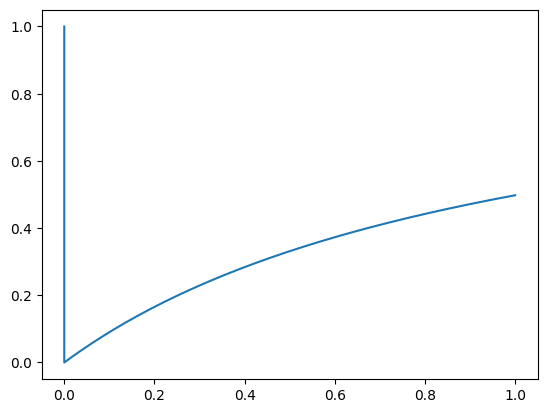

In [136]:
from collections import Counter
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve, auc
from matplotlib import pyplot as plt


a = Counter(true_labels)

pos_percentage = a[1] / len(true_labels)

precision, recall, thresholds = precision_recall_curve(true_labels, probs)

print(auc(recall, precision) - pos_percentage)

plt.plot(recall, precision)

In [9]:
number

1358

In [12]:
len(task_iterable._data_paths) // task_iterable._reader_chunk_size

4938

In [4]:
iterator = iter(task_iterable)

In [6]:
len(iterator)

TypeError: object of type 'generator' has no len()

In [5]:
from tqdm import tqdm


number_of_tasks = 0

for datapoint in tqdm(iterator):
    number_of_tasks += 1

1713it [02:25, 11.79it/s]


KeyboardInterrupt: 

In [69]:
a = next(task_iter)

TypeError: object of type 'FSMolTaskSample' has no len()

In [75]:
a.train_samples[0].graph

GraphData(node_features=array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0.

In [77]:
a.train_samples[0].graph.adjacency_lists

[array([[ 0,  1],
        [ 1,  2],
        [ 3,  4],
        [ 5,  6],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [10, 12],
        [13, 14],
        [ 5, 15],
        [16, 17],
        [18, 19],
        [20, 21],
        [21, 22],
        [22, 23],
        [23, 24],
        [24, 25],
        [25, 26],
        [26, 27],
        [26, 28],
        [28, 29],
        [20,  2],
        [29, 23],
        [18,  4],
        [13,  7]]),
 array([[ 2,  3],
        [ 4,  5],
        [ 7,  8],
        [ 9, 10],
        [12, 13],
        [15, 16],
        [17, 18],
        [19, 20]]),
 array([], shape=(0, 2), dtype=int64)]

In [79]:
import torch

from torch_geometric.data import Data

def convert_to_pyg_graph(graph):
    x = torch.tensor(graph.node_features)
    adjacency_lists = graph.adjacency_lists

    single_bonds = adjacency_lists[0]
    double_bonds = adjacency_lists[1]
    triple_bonds =  adjacency_lists[2]

    edge_index = torch.cat(list(map(torch.tensor, adjacency_lists)), dim=0).t().contiguous()

    edge_feats = [0 for bond in single_bonds] + [1 for bond in double_bonds] + [2 for bond in triple_bonds]

    return Data(x=x, edge_index=edge_index, edge_attr=edge_feats)


convert_to_pyg_graph(a.train_samples[0].graph)

Data(x=[30, 32], edge_index=[2, 33], edge_attr=[33])

In [83]:
a.train_samples[0].graph.adjacency_lists[1].shape

(8, 2)

In [7]:
q = next(task_iter)

In [8]:
task_sampler = StratifiedTaskSampler(
    train_size_or_ratio=64, test_size_or_ratio=256
)

task_sampler.sample(q)

DatasetTooSmallException: Cannot satisfy request to split dataset as specified because the dataset is too small.
  Task name: CHEMBL1261338
  Number of samples: 51
  Requested sample: 64 train, 0 valid, -13 test samples.

In [8]:
proto_net_task_sample_interable = get_protonet_task_sample_iterable(
        dataset=fsmol_dataset,
        data_fold=DataFold.TRAIN,
        num_samples=1,
        max_num_graphs=256,
        support_size=64,
        query_size=256,
        repeat=True,
    )

In [10]:
train_task_sample_iterator = iter(proto_net_task_sample_interable)

In [9]:
from fs_mol.utils.torch_utils import torchify


task_sample = next(train_task_sample_iterator)

example = torchify(task_sample, device='cuda')

print(f'Number of Positive Samples: {example.num_positive_support_samples}')
print(f'Number of Negative Samples: {example.num_support_samples - example.num_positive_support_samples}')

Number of Positive Samples: 30
Number of Negative Samples: 34


In [17]:
example.batches[0]

ProtoNetBatch(support_features=MoleculeProtoNetFeatures(num_graphs=64, num_nodes=1578, num_edges=1752, node_features=tensor([[0., 1., 0.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 1., 0., 1.],
        [0., 0., 1.,  ..., 1., 0., 1.],
        ...,
        [0., 1., 0.,  ..., 1., 0., 1.],
        [0., 1., 0.,  ..., 1., 0., 1.],
        [0., 1., 0.,  ..., 1., 0., 1.]], device='cuda:0'), adjacency_lists=[tensor([[   0,    1],
        [   1,    2],
        [   3,    4],
        ...,
        [1576, 1577],
        [1577, 1563],
        [1575, 1570]], device='cuda:0'), tensor([[   2,    3],
        [   4,    5],
        [   6,    7],
        ...,
        [1570, 1571],
        [1572, 1573],
        [1574, 1575]], device='cuda:0'), tensor([[ 320,  321],
        [ 442,  443],
        [ 531,  532],
        [1043, 1044],
        [1057, 1058],
        [1059, 1060]], device='cuda:0')], edge_features=[tensor([], device='cuda:0', size=(1175, 0)), tensor([], device='cuda:0', size=(571, 0)), tensor([],

In [12]:
from typing import Optional, Tuple

from fs_mol.models.protonet import PrototypicalNetworkConfig


model = PrototypicalNetwork(config=PrototypicalNetworkConfig())

In [18]:
import torch

torch.onnx.export(model, example.batches[0], 'rnn.onnx')

RuntimeError: Only tuples, lists and Variables are supported as JIT inputs/outputs. Dictionaries and strings are also accepted, but their usage is not recommended. Here, received an input of unsupported type: ProtoNetBatch

In [ ]:
epochs = 10


for _ in epochs:
    batch = torchify(next(train_task_sample_iterator), device=device)

    x = batch.batches
    y = batch.batch_labels


    